# Image Display Examples

In [1]:
from __future__ import print_function, unicode_literals, division, absolute_import

import io

import IPython
from ipywidgets import widgets
import PIL.Image

from widget_canvas import CanvasImage
from widget_canvas.image import read

<IPython.core.display.Javascript object>

## Load some image data

In [2]:
data_image = read('images/Whippet.jpg')

data_image.shape

(220, 320, 3)

---

## Matplotlib imshow()

[Matplotlib](http://matplotlib.org/) is a great high-quality data display tool used by lots of people for a long time.  It has long been my first choice for interactive data exploration on my PC when I want a native GUI framework.  But when I use the IPython Notebook I want my interactive display tools to live entirely in the world of HTML and JavaScript.  Static image display works fine enough (see the example below), but fully-interactive displays are still a [work in progress](http://matplotlib.org/users/whats_new.html#webagg-backend).  Ultimately I need compatibility with IPython widgets and Matplotlib is not there yet.

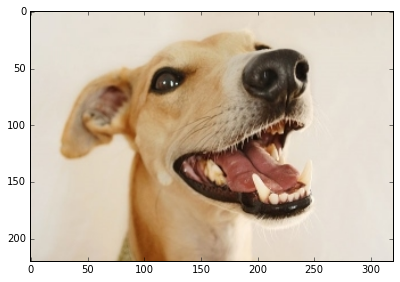

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(data_image)

plt.tight_layout()

---

## IPython's Built-in Image Widget

The IPython built-in image widget accepts as input a string of byte data representing an already-compressed image.  The compressed image data is synchronized from the Python backend to the Notebook's Javascript frontend and copied into the widget's [image](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/img) element for display.

The upside of this display widget is simplicity of implementaion.  The downside is the depth of understanding and complexity of implementation required of the user.  I want an easy-to-use image display widget that readily accepts Numpy arrays as input.

In [4]:
def compress_to_bytes(data, fmt):
    """
    Helper function to compress image data via PIL/Pillow.
    """
    buff = io.BytesIO()
    img = PIL.Image.fromarray(data)    
    img.save(buff, format=fmt)
    
    return buff.getvalue()

In [5]:
# Compress the image data.
fmt = 'png'
data_comp = compress_to_bytes(data_image, fmt)

# Display first 100 bytes of compressed data just for fun.
data_comp[:100]

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01@\x00\x00\x00\xdc\x08\x02\x00\x00\x00\x8e!\xefq\x00\x01\x00\x00IDATx\x9c\xe4\xfdk\x8clIz\x18\x88}\x8f\x888\xe7df\xd5}\xf6\xbbgz\x86\xc3\x19\x92\x1aR\x14\x89\xb5D\xd3\xbb\x14\xb0X\x0b\x96\x0c\x18\xb2`\xac\xe1\xc5b\x01\x1bX\xfb\xf7\xc20\x0cx\xe1'

In [6]:
# Built-in IPython image widget.
wid_builtin = widgets.Image(value=data_comp)

wid_builtin.border_color = 'black'
wid_builtin.border_width = 2

wid_builtin

In [7]:
# At one point during development the above image was stretched out to the full width of containing cell. 
# Not sure why. The two lines below are meant to address that problem.
wid_builtin.width = data_image.shape[1]
wid_builtin.height = data_image.shape[0]

---

## Canvas Element with Basic HTML and JavaScript

The HTML5 [Canvas Element](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/canvas) is a great tool for displaying images and drawing artwork onto a bitmap surface in the browser.  It has built-in support for mouse events plus size and rotation transforms.

The example below uses HTML and JavaScript to display an image to a canvas element.  But since the image originates from a local data file and not a remote URL, a special URL form must be used to encode the image data into something compatible. See [mozilla](https://developer.mozilla.org/en-US/docs/Web/HTTP/data_URIs) and [wikipedia](https://en.wikipedia.org/wiki/Data_URI_scheme) for details.

The above example already compressed the original image data into a sequence of bytes.  Now those bytes need to be encoded into a form that will survive delivery over the internet.

```xml
data:[<MIME-type>][;charset=<encoding>][;base64],<data>
```

In [8]:
import base64

data_encode = base64.b64encode(data_comp)

# Display first 100 bytes of compressed and encoded data just for fun.
data_encode[:100]

b'iVBORw0KGgoAAAANSUhEUgAAAUAAAADcCAIAAACOIe9xAAEAAElEQVR4nOT9a4xsSXoYiH2PiDjnZGbVffa7Z3qGwxmSGlIUibVE'

In [9]:
# Compare sizes.
print('Original Image:      {:7d} bytes (raw)'.format(data_image.size))
print('Compressed:          {:7d} bytes ({})'.format(len(data_comp), fmt))
print('Compressed & Encoded:{:7d} bytes (base64)'.format(len(data_encode)))

Original Image:       211200 bytes (raw)
Compressed:            81461 bytes (png)
Compressed & Encoded: 108616 bytes (base64)


In [10]:
# The decoding step here is necesary since we need to interpret byte data as text.
# See this link for a nice explanation:
# http://stackoverflow.com/questions/14010551/how-to-convert-between-bytes-and-strings-in-python-3

enc = 'utf-8'
data_url = 'data:image/{:s};charset={};base64,{:s}'.format(fmt, enc, data_encode.decode(encoding=enc))

So that takes care of getting the data ready.  Next we use some HTML and JavaScript to display the image right here in the notebook.

In [11]:
doc_html = \
"""
<html>
    <head></head>
    <body>
        <canvas id='hello_example' style='border: solid black 2px'/>
    </body>
</html>
"""

template_js = \
"""
// Embedded data URI goes right here.
var url = "{}"

// Get the canvas element plus corresponding drawing context
var canvas = document.getElementById('hello_example');
var context = canvas.getContext('2d');

// Create a hidden <img> element to manage incoming data.
var img = new Image();

// Add new-data event handler to the hidden <img> element.
img.onload = function () {{
    // This function will be called when new image data has finished loading
    // into the <img> element.  This new data will be the source for drawing
    // onto the Canvas.

    // Set canvas geometry.
    canvas.width = img.width
    canvas.style.width = img.width + 'px'

    canvas.height = img.height
    canvas.style.height = img.height + 'px'

    // Draw new image data onto the Canvas.
    context.drawImage(img, 0, 0);
}}

// Assign image URL.
img.src = url
"""

doc_js = template_js.format(data_url)

In [12]:
# Display the HTML via IPython display hook.
IPython.display.display_html(doc_html, raw=True)

# Update HTML canvas element with some JavaScript.
IPython.display.display_javascript(doc_js, raw=True)

---

## My New Canvas Widget

My new canvas widget is simpler to use than IPython's built-in image display widget since it takes a Numpy array as input.  Behind the scenes it takes care of compressing and encoding the data and then feeding it into the canvas element in a manner similar to the example just above.

In [13]:
wid_canvas = CanvasImage(data_image)

wid_canvas.border_color = 'black'
wid_canvas.border_width = 2

wid_canvas

Modifying the image data in place is as easy as any other notebook widget.

In [14]:
data_image_2 = read('images/Doberman.jpg')

wid_canvas.data = data_image_2